In [14]:
import ratio
import numpy as np
import matplotlib.pyplot as plt

# Load packages
import json
import matplotlib.pyplot as plt
import numpy as np
import openturns as ot
import pandas as pd
import scipy
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from bokeh.io import output_notebook, push_notebook, show
from bokeh.plotting import figure
from bokeh.transform import linear_cmap

#from ggplot import *
from sklearn import cluster, mixture
from sklearn.decomposition import PCA
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from fda import *

output_notebook()

Loading BokehJS ...

In [15]:
# Various paramaters
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['font.size'] = 15
plt.rcParams['lines.markersize'] = 4
plt.rcParams['axes.linewidth'] = 0.2
plt.rcParams['xtick.major.width'] = 0.2
plt.rcParams['ytick.major.width'] = 0.2

plt.rcParams['text.usetex'] = False
plt.rcParams['font.serif'] = "cm"

In [92]:
# Some functions
def plot_month(data, date):
    """Plot the data for one month."""
    df = data.loc[date]

    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(df)
    ax.set_xlim([0, len(df)-1])
    
    plt.title(' '.join(['Manufacturing month:', date]))
    plt.xlabel('Month since manufacturing')
    plt.ylabel('Cost by vehicle')
    plt.xticks(np.arange(0, len(df), 2))
    plt.grid()
    plt.show()

def plot_months(data,length=25):
    """Plot the data for all the months."""
    df = data.T
     
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(df)
    ax.set_xlim([0, length])
    
    plt.title('Warranty cost')
    plt.xlabel('Month since manufacturing')
    plt.xticks(np.arange(0, length, 2))
    plt.ylabel('Cost per vehicle')
    plt.grid()
    plt.show()
    
def plot_coefs(data, number):
    """Plot the coefficient of a principal component through time."""
    df = data[number]
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(month, df)
    
    plt.title(' '.join(['Plot of the scores of the', str(number), 'principal components']))
    plt.xlabel('Months')
    plt.xticks(rotation=45)
    plt.ylabel('Principal components scores')
    plt.grid()
    plt.show()

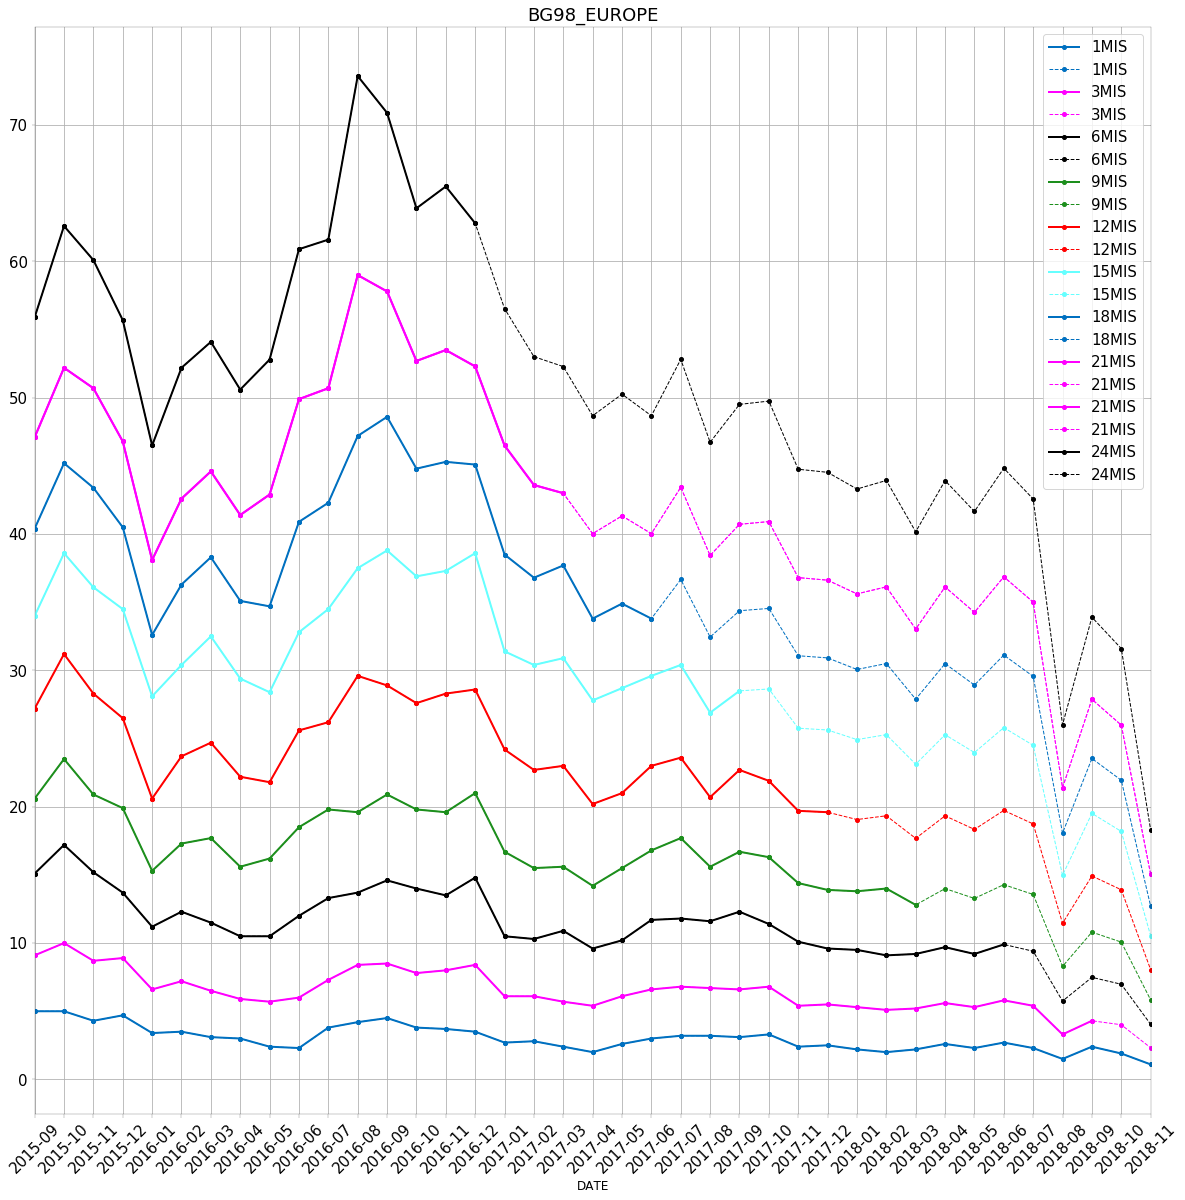

In [17]:
csvFilename = "BG98_EUROPE.csv"

r = ratio.ratioCore()

r.getData(csvFilename)
r.plotMis(["1MIS", "3MIS", "6MIS", "9MIS", "12MIS", "15MIS", "18MIS", "21MIS", "21MIS", "24MIS"])
r.calculateRatio(["21/6MIS", "21/3MIS"])

In [93]:
# Load the data
df = pd.read_csv('./B98.csv', header=None, index_col=0)
# Build the cumulative dataframe.
df_cum = df.cumsum(axis=1)
# Plot all the months (cumulative costs)
plot_months(df_cum)

In [94]:
data = r.data

mis = ["0MIS","1MIS", "3MIS", "6MIS", "9MIS", "12MIS", "15MIS", "18MIS", "21MIS", "24MIS"]

cout=[]
columns=[]
for i in range(len(data)):
    month_cout=[]
    month_data = data.loc[i]

    for m in mis:   
        if(i==0):
            if(len(m)==4):
                month = int(m[0])
            elif(len(m)==5):
                month = int(m[0:2])
            columns.append(month)
        
        month_cout.append(month_data[m])
    cout.append(month_cout)

cout=np.array(cout)


df = pd.DataFrame(cout, index = data["DATE"],columns=columns)


plot_months(df)


In [95]:
plot_months(df_cum)

df_res = pd.concat([df_cum,df])


plot_months(df_res)